# Ejercicio 15

Implemente (i.e. no reutilice funciones de scikit-learn):

1. Leave-One-Out Cross-Validation

2. k-Fold Cross-Validation

para calcular el error cuadrático medio como función del orden polinomial de un ajuste de Price como funcion de Horsepower. Intente con polinomios de orden 1 hasta 10. Compare esas dos graficas con el Criterio de informacion Bayesiana como funcion del orden del polinomio.

La solución debe estar en un notebook que asuma que el archivo de datos se encuentra en el mismo directorio que el notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Leemos los datos
data = pd.read_csv('Cars93.csv')

In [25]:
#Definimos el modelo de tal forma que nos sirva para un polinomio de cualquier grado.
#Lo definimos de esta manera porque más adelante la función polytfit nos devuelve los coeficientes del de mayor grado
#al de menor grado.
def model(x, coefs):
    y = np.zeros(len(x))
    p = len(coefs)
    for i in range(p):
        y += coefs[i] * x**(p-i-1)
    return y
#Definimos el error cuadrático medio.
def mse(y_a, y_b):
    d = (y_a - y_b)**2
    return d.mean()

Para usar Bayes planteamos la siguiente verosimilitud
$$
\mathcal{L}({x_i, y_i, \sigma_i}|m, b) = \prod_{i=1}^{N}\exp\left[-\frac{1}{2}\left(\frac{y_i - y_{model}(x_i, m, b)}{\sigma_i}\right)^2\right]
$$

Además, usaremos el Bayesian Information Criterion, que para alta dimensionalidad se puede definir como: 
$$
BIC=ln(p_n)k-2ln(\hat L)
$$

Donde $p_n$ es el número de variables, $k$ es el número de parámetros en el modelo y $\hat L$ es el logaritmo de la función de verosimilitud.
Ver: https://en.wikipedia.org/wiki/Bayesian_information_criterion

In [26]:
def bic(y_obs, y_model, p=2):
    n = len(y_obs)
    sigma = np.std(y_obs)
    #Usamos el logaritmo de la función de verosimilitud.
    loglike = np.sum(-0.5*(y_obs-y_model)**2/sigma**2)
    #Debemos agregarle un factor de normalización ya que básicamente nuestra función de verosimilitud tiene la forma
    #de una gaussiana. EL factor de normalización va dividiendo en la expresión para la verosimilitud pero en el logaritmo va
    #restando. Y lo hace para el número de variables, n.
    loglike -= n * np.log(np.sqrt(2.0 * np.pi * sigma**2))
    return np.log(n) * (p+1) - 2.0*loglike

Ahora haremos cross-validation. Esto es, partir el set de datos en diferentes grupos de train y validation.

- Leave-one-out deja todos en train y coge uno solo para validation. Es decir, cada dato forma un grupo de validation, por lo que se tienen tantos grupos como número de datos.

- K-fold parte el set en k grupos.

In [27]:
#Esta parte es genérica, no le interesa el método.
def cross_validation(X, Y, n_groups=2, p=2):
    n_points = len(Y)
    #Crea un vector entre cero y el número de puntos (de a 1).
    ids = np.arange(n_points)
    #El operador modulo lo que hace es asignarle un grupo a cada dato de acuerdo con el número de grupos que se establezca.
    #Digamos que número de grupos es 6. Entonces group_ids se verá: [0 1 2 3 4 5 6 0 1 2 3 4 5 6 ...] Es decir, el residuo
    #con cada número va a variar de a 1 y se va a reiniciar con periodicidad igual al tamaño de grupos. Con esto le asignamos
    #un grupo a cada dato.
    group_ids = ids % n_groups
    #Creamos un array para guardar los mses de cada grupo.
    mse_groups = np.zeros(n_groups)
    #Ahora creamos los grupos.
    for i in range(n_groups):
        #Todos los de un mismo grupo forman el set de validation.
        ii = (group_ids ==i)
        validation_X = X[ii]
        #El resto corresponde al grupo de train.
        train_X = X[~ii]
        
        #Partimos también Y.
        validation_Y = Y[ii]
        train_Y = Y[~ii]
        
        #Fiteamos el modelo con los datos de train. Polyfit nos devuelve los coeficientes del polinomio de grado p.
        c = np.polyfit(train_X, train_Y, p)
        #Predecimos los datos del set de validation.
        Y_model = model(validation_X, c)
        #Calculamos el mse para los datos de validation
        mse_groups[i] = mse(Y_model, validation_Y)
        
    #Lo que devolvemos es la media de todos los grupos.
    return mse_groups.mean()

# Leave-One-Out

Recordemos que Leave-one-out deja todos en train y coge uno solo para validation. Es decir, cada dato forma un grupo de validation, por lo que se tienen tantos grupos como número de datos.

Text(0,0.5,'Leave One Out MSE')

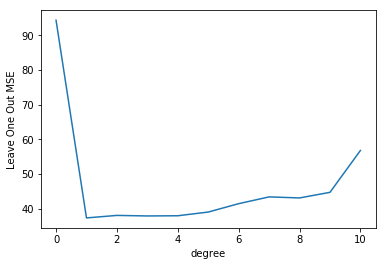

In [28]:
X = np.array(data['Horsepower'], dtype=float)
Y = np.array(data['Price'], dtype=float)

degrees = np.arange(11)
n_degrees = len(degrees)
SV_leave_one_out = np.zeros(n_degrees)

#Lo hacemos para cada grado de polinomio. El número de grupos es el mismo número de datos.
for i in range(n_degrees):
    SV_leave_one_out[i]  = cross_validation(X,Y, n_groups=len(X), p=degrees[i])

plt.plot(degrees, SV_leave_one_out)
plt.xlabel("degree")
plt.ylabel("Leave One Out MSE")

# K-fold

K-fold por su parte, divide el set de datos en k grupos. Tomaremos k=10

Text(0,0.5,'k-fold MSE (k=10)')

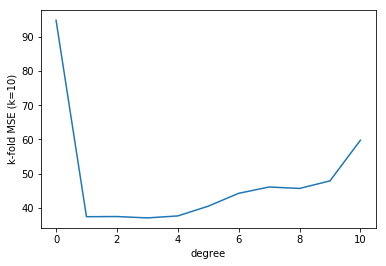

In [29]:
X = np.array(data['Horsepower'], dtype=float)
Y = np.array(data['Price'], dtype=float)

degrees = np.arange(11)
n_degrees = len(degrees)
SV_kfold = np.zeros(n_degrees)

for i in range(n_degrees):
    SV_kfold[i]  = cross_validation(X,Y, n_groups=10, p=degrees[i])

plt.plot(degrees, SV_kfold)
plt.xlabel("degree")
plt.ylabel("k-fold MSE (k=10)")

# Bayesian Information Criterion

Text(0,0.5,'Bayesian Information Criterion')

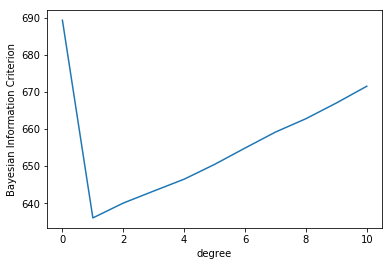

In [30]:
X = np.array(data['Horsepower'], dtype=float)
Y = np.array(data['Price'], dtype=float)

degrees = np.arange(11)
n_degrees = len(degrees)
BIC_degree = np.zeros(n_degrees)

for i in range(n_degrees):
    c = np.polyfit(X, Y, degrees[i])
    Y_model = model(X, c)
    BIC_degree[i] = bic(Y, Y_model, p=degrees[i])

plt.plot(degrees, BIC_degree)
plt.xlabel("degree")
plt.ylabel("Bayesian Information Criterion")

# Notar que todos convergen en que el polinomio de grado 1 es el de menor MSE